# IFT 6758 - Devoir 4

### Interprétabilité du modèle, Explicabilité, Sélection et Ingénierie de caractéristiques

**Ce devoir a pour objectif de vous donner plus d'expérience pratique dans les domaines de l'interprétabilité du modèle, de la sélection des caractéristiques et de l'ingénierie des caractéristiques.**

Évaluation dans ce jupyter notebook :

- Sorties et graphiques
- Résultats imprimés issus de l'exécution de fonctions
- Questions à réponse courte

In [1]:
import pandas as pd
import numpy as np
import eli5
from sklearn.ensemble import RandomForestRegressor
from hw5 import *

/opt/anaconda3/envs/sklearn_env_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Partie 1 : Interprétabilité et Explicabilité du Modèle

## 1. Chargement des Données

### Chargement de l'ensemble de données des réadmissions

Nous commencerons par charger notre ensemble de données et vérifier un petit échantillon.

In [2]:
path = "data/hospital.csv"
raw_df = load_data(path)

In [3]:
# Vérification d'un échantillon de 5 patients
np.random.seed(0)
raw_df.sample(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,...,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,is_readmitted
14149,1,36,1,20,2,0,0,5,True,False,...,True,False,True,True,True,True,True,False,True,True
8946,3,37,2,37,0,0,1,9,True,False,...,True,False,True,True,True,True,True,False,True,False
22378,2,68,0,16,1,0,5,7,True,False,...,True,True,True,True,True,True,True,True,False,False
12162,12,76,1,30,0,0,2,9,True,False,...,True,False,True,True,True,True,True,False,True,True
4879,4,19,3,9,0,0,0,9,True,False,...,True,True,True,True,True,True,True,True,False,True


Nous pouvons vérifier les noms de toutes les colonnes de notre ensemble de données :

In [4]:
# Vérification des noms des 65 colonnes de notre ensemble de données
raw_df.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

Nous pouvons également vérifier leurs types de données :

In [5]:
# Vérification des types de données du dataframe brut
raw_df.dtypes

time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
                              ...  
metformin-rosiglitazone_No     bool
metformin-pioglitazone_No      bool
change_No                      bool
diabetesMed_Yes                bool
is_readmitted                  bool
Length: 65, dtype: object

Ici, vous avez un bref aperçu de la manière d'interpréter chaque nom de colonne :

- La colonne portant le nom `is_readmitted` est notre cible de prédiction. C'est ce que notre modèle devrait être en mesure de classifier correctement. Remarquez que les valeurs de cette colonne sont booléennes et que nous devrons les mapper en 1 et 0 avant d'entraîner notre modèle.
- Les colonnes avec le mot `diag` indiquent le code de diagnostic de la maladie ou des maladies pour lesquelles le patient a été admis. Par exemple, `diag_1_428` signifie que le médecin a donné le diagnostic de la première maladie comme "428". Ces codes pourraient être consultés dans un répertoire de codes médicaux, mais sans plus d'informations médicales, ils ne signifieraient rien pour nous de toute façon.
- Les colonnes avec des noms comme `glimepiride_No` signifient que le patient n'a pas pris le médicament `x`. Dans cet exemple, le médicament est `glimepiride`. Si cette caractéristique avait une valeur de False, cela signifierait que le patient a pris le médicament `glimepiride`.
- Les caractéristiques dont les noms commencent par `medical_specialty` décrivent la spécialité du médecin qui voit le patient. Les valeurs de ces champs sont toutes `True` ou `False`.

Nous vérifions s'il y a des valeurs manquantes dans notre ensemble de données.

In [6]:
# Vérifier s'il y a des valeurs manquantes (NA)
raw_df.isna().any(axis=1).sum() 

0

Enfin, nous encoderons notre cible de prédiction. Complétez la méthode `encode_target_column()` dans `hw5.py`.

In [7]:
df = encode_target_column(raw_df)
df.head(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,...,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,is_readmitted
0,14,41,0,11,0,0,0,6,True,False,...,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,...,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,...,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,...,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,...,True,True,True,True,True,True,True,True,False,0


## 2. Interprétation du Modèle

Imaginons que nous ayons choisi un modèle simple qui prédit si un patient sera réadmis à l'hôpital, mais les médecins (nos principales parties prenantes) disent qu'ils ne savent pas comment évaluer un modèle et ils aimeraient que nous leur montrions des preuves que le modèle est en ligne avec leur intuition médicale.

Ils sont très occupés à sauver des vies et ils n'ont pas le temps pour des graphiques ou des rapports compliqués. Nous devons produire une représentation qui résume notre aperçu du modèle en 1 ou 2 graphiques.

Tout d'abord, nous devons préparer notre ensemble de données pour l'entraînement du modèle et l'évaluation du modèle. Nous utiliserons la fonction `split_data()` de notre fichier `hw5.py` pour diviser notre ensemble de données en X_train, y_train, X_val et y_val. Nous sommes de jeunes scientifiques des données et nous croyons que toutes les fonctionnalités sont utiles pour prédire si un patient sera réadmis (je sais que vous savez que c'est faux, mais jouons le jeu pour l'exercice).

In [8]:
# Diviser l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = split_data(df, "is_readmitted")

Le modèle que nous avons choisi est un modèle de `Random Forest`. Nous allons entraîner et tester notre modèle sur les subdivisions de la cellule précédente. Ici, vous devrez compléter la méthode `train_random_forest()` du fichier `hw5.py`.

In [9]:
firstModel = train_random_forest(X_train, y_train)

Nous sommes novices dans le domaine de la science des données médicales, mais nous savons qu'un rapport de classification pourrait nous aider à montrer que le modèle effectue son travail. Ici, vous devrez compléter la méthode `evaluate_model()` de `hw5.py`, car elle nous aidera à obtenir la précision de notre modèle et notre rapport de classification.

In [10]:
acc, report = evaluate_model(firstModel, X_val, y_val)
print(f"The accuracy of our model is: {acc}")
print(report)

The accuracy of our model is: 0.6116
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      2731
           1       0.59      0.47      0.53      2269

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.61      0.61      0.61      5000



### 2.1 Importance des Caractéristiques

Ouch ! Nous n'avons pas fait très bien. Cependant, la science des données est un processus d'amélioration continue, et nous savons que nous pourrions améliorer ce modèle si nous comprenons comment nos caractéristiques interagissent avec notre modèle.

Nous restons calmes et nous nous souvenons que nous pouvons interroger notre modèle pour identifier les caractéristiques qui ont le plus d'impact sur la prédiction. Il existe plusieurs façons de le faire, mais nous décidons de travailler avec l'`importance par permutation` (elle est rapide à calculer, largement utilisée et comprise, et elle est conforme aux propriétés que nous souhaiterions qu'une mesure d'importance des caractéristiques ait).

L'importance par permutation est calculée après qu'un modèle a été ajusté. Nous ne changerons pas le modèle ni les prédictions que nous obtiendrions pour un ensemble de caractéristiques donné. Cette mesure nous aidera à répondre à la question : Si je mélange aléatoirement une colonne unique des données de validation, en laissant la cible et toutes les autres colonnes en place, comment cela affecterait-il la précision des prédictions dans ces données maintenant mélangées ? L'intuition derrière cela est que la précision du modèle souffre particulièrement si nous mélangeons une colonne sur laquelle le modèle s'appuie fortement pour ses prédictions.

Ici, vous devrez compléter la méthode `calculate_permutation_importance()`, qui nous permettra de calculer les importances par permutation des caractéristiques utilisées. Nous les montrerons ensuite à l'aide de la fonction `eli5.show_weights()`.

In [11]:
feature_names = X_val.columns.tolist()
perm = calculate_permutation_importance(firstModel, X_val, y_val)

In [12]:
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0460 ± 0.0117,number_inpatient
0.0074 ± 0.0052,number_emergency
0.0068 ± 0.0041,number_outpatient
0.0039 ± 0.0055,num_lab_procedures
0.0030 ± 0.0021,diag_1_428
0.0024 ± 0.0036,payer_code_MC
0.0022 ± 0.0019,diag_2_250
0.0021 ± 0.0037,change_No
0.0016 ± 0.0029,diag_2_428
0.0016 ± 0.0037,diag_3_250


**Question 1**

1-. Quelle semble être la caractéristique la plus importante ?

La caractéristique qui semble être la plus importante est `number_inpatient`.

---------------------------------------------------------------

**Interprétation des Importances par Permutation**

Les valeurs en haut sont les caractéristiques les plus importantes, et celles en bas sont les moins importantes.

Le premier nombre dans chaque ligne indique de combien les performances du modèle ont diminué avec un mélange aléatoire (dans ce cas, en utilisant "l'exactitude" comme mesure de performance). Le nombre après le ± mesure comment les performances ont varié d'un mélange à l'autre.

Il est possible de voir des valeurs négatives pour les importances par permutation. Dans ces cas, les prédictions sur les données mélangées (ou bruitées) se sont avérées plus précises que sur les données réelles. Cela se produit lorsque la caractéristique n'avait pas d'importance (elle aurait dû avoir une importance proche de 0), mais le hasard a fait que les prédictions sur les données mélangées étaient plus précises.

----------------------------------------------------

### 2.2 Graphiques de Dépendance Partielle

Nous montrons nos conclusions aux médecins. Ils ne semblent pas trop impressionnés par les performances de notre modèle, mais ils aimeraient en savoir plus sur la caractéristique que le modèle a identifiée comme la plus importante. Nous allons créer un graphique pour leur montrer comment la caractéristique principale affecte les prédictions du modèle. Pour ce faire, vous devrez compléter la méthode `plot_partial_dependence()` de `solution.py`, qui nous aidera à afficher un graphique de dépendance partielle.

Alors que l'importance des caractéristiques montre quelles variables affectent le plus les prédictions, les graphiques de dépendance partielle montrent comment une caractéristique affecte les prédictions. Si vous êtes familier avec les modèles de régression linéaire ou logistique, les graphiques de dépendance partielle peuvent être interprétés de manière similaire aux coefficients de ces modèles. Cependant, les graphiques de dépendance partielle sur des modèles sophistiqués peuvent capturer des motifs plus complexes que les coefficients des modèles simples.

Les graphiques de dépendance partielle sont calculés après qu'un modèle a été ajusté. Le modèle est ajusté sur des données réelles qui n'ont pas été manipulées de quelque manière que ce soit.

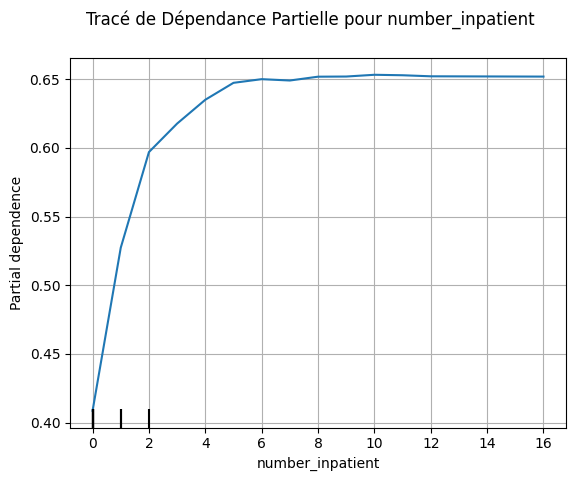

In [13]:
topFeature="number_inpatient"
plot_partial_dependence(firstModel, X_val, topFeature)

Nous montrons notre graphique aux médecins et ils pensent que c'est un bon signe que l'augmentation du nombre de procédures hospitalières entraîne une augmentation des prédictions. Mais ils ne peuvent pas dire à partir de ce graphique si ce changement est important ou non. Ils aimeraient que nous en fassions un semblable pour `time_in_hospital` pour voir comment cela se compare. Voyons comment ça se passe :

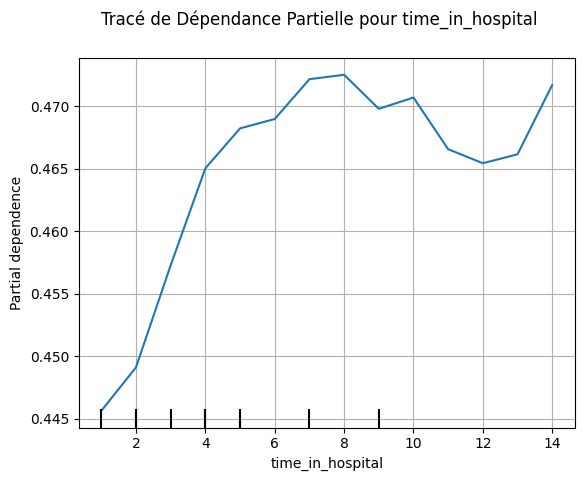

In [14]:
plot_partial_dependence(firstModel,X_val,"time_in_hospital")

Il semble que `time_in_hospital` n'ait aucune importance du tout. La différence entre la valeur la plus basse sur le graphique de dépendance partielle et la valeur la plus élevée est d'environ 5 %.

Si c'est ce que notre modèle a conclu, les médecins le croiront. Mais pour eux, cela semble si faible. Est-il possible que les données soient incorrectes, ou notre modèle fait-il quelque chose de plus complexe que ce à quoi ils s'attendent ?

Ils aimeraient que nous leur montrions le taux de réadmission brut pour chaque valeur de `time_in_hospital` pour voir comment cela se compare au graphique de dépendance partielle.

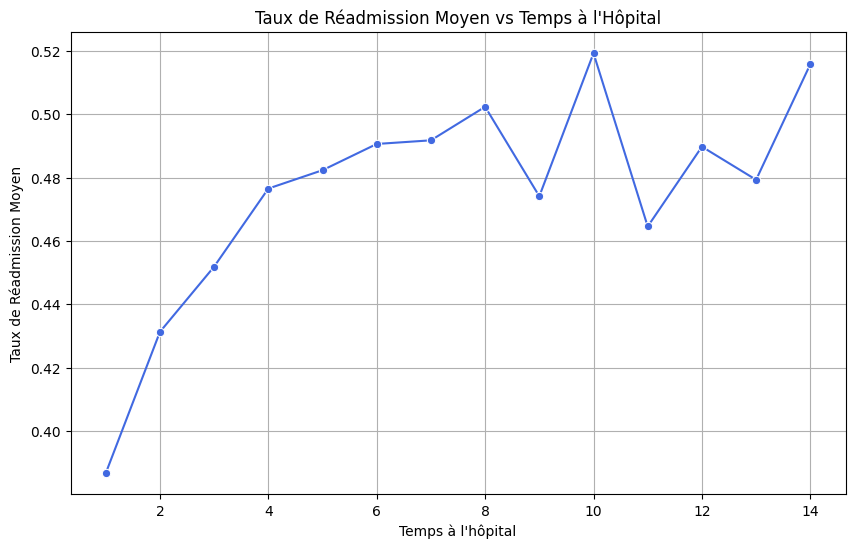

In [15]:
plot_mean_readmission_vs_time(X_train,y_train)

## 3. Explicabilité du Modèle (Bonus)

### 3.1 Valeurs SHAP

Après avoir visionné cela, les médecins sont convaincus que nous avons les bonnes données, et un aperçu du modèle semblait raisonnable pour un premier essai. Il est temps de transformer cela en un produit fini qu'ils peuvent utiliser et tester (dans la vraie vie, cela ne se produirait pas, car les modèles doivent passer une série de contrôles et de réglementations stricts avant d'être utilisés dans des environnements médicaux réels, mais l'idée ici est de vous montrer comment utiliser ces outils et d'être suffisamment familiarisé pour les appliquer dans notre projet de cours). Plus précisément, l'hôpital souhaite que vous créiez une fonction `main_factors()` qui fait ce qui suit :
- Prend une seule ligne de données de patient (du même format que nos données traitées)
- Crée une visualisation montrant quelles caractéristiques de ce patient ont augmenté leur risque de réadmission, quelles caractéristiques l'ont diminué, et dans quelle mesure ces caractéristiques ont de l'importance.

Il n'est pas important de montrer chaque caractéristique avec chaque impact minuscule sur le risque de réadmission. Il est acceptable de se concentrer uniquement sur les caractéristiques les plus importantes pour ce patient.

--------------------------------------

Jusqu'à présent, nous avons travaillé avec certaines techniques pour extraire des informations générales à partir d'un modèle d'apprentissage automatique. Mais que se passe-t-il si nous voulons décomposer le fonctionnement du modèle pour une prédiction individuelle ?

Les valeurs SHAP (un acronyme de SHapley Additive exPlanations) décomposent une prédiction pour montrer l'impact de chaque caractéristique. Où pourriez-vous utiliser cela ? Imaginez les scénarios suivants :

    - Un modèle indique qu'une banque ne devrait pas accorder un prêt à quelqu'un, et la banque est légalement tenue d'expliquer les raisons de chaque refus de prêt (nous commençons à voir de plus en plus de réglementations exigeant de l'explicabilité des modèles pour ce type d'applications en ML).
    - Un fournisseur de soins de santé souhaite identifier les facteurs qui influent sur le risque de contracter une maladie pour chaque patient, afin de pouvoir intervenir directement sur ces facteurs de risque avec des interventions médicales ciblées (c'est également important d'un point de vue réglementaire, car les fournisseurs de soins de santé doivent fournir des preuves claires sur la manière dont un patient a été diagnostiqué et la raison derrière un plan de traitement spécifique).

**Comment fonctionnent les valeurs SHAP ?**

Les valeurs SHAP interprètent l'impact d'avoir une certaine valeur pour une caractéristique donnée par rapport à la prédiction que nous ferions si cette caractéristique prenait une valeur de référence. Les valeurs SHAP le font de manière à garantir une belle propriété. Plus précisément, vous décomposez une prédiction avec l'équation suivante :

somme(des valeurs SHAP de toutes les caractéristiques) = prédiction_pour_réadmission - prédiction_pour_valeurs_de_base

C'est-à-dire que les valeurs SHAP de toutes les caractéristiques se cumulent pour expliquer pourquoi ma prédiction était différente de la valeur de base. Cela nous aide à expliquer pourquoi le modèle a identifié un patient pour une réadmission ou non.

--------------------------------------------------------------------------

In [16]:
sample_patient = X_val.iloc[0].astype(float)

In [17]:
main_factors(firstModel, sample_patient)

--------------------------------------------------

**Comment interprétez-vous cela ?**

Les valeurs des caractéristiques qui augmentent les prédictions sont en rouge, et leur taille visuelle montre l'ampleur de l'effet de la caractéristique. Les valeurs des caractéristiques qui diminuent la prédiction sont en bleu.

Si vous soustrayez la longueur des barres bleues de la longueur des barres rouges, cela équivaut à la distance de la valeur de base à la sortie.

Il y a une certaine complexité dans la technique, pour s'assurer que la valeur de base plus la somme des effets individuels s'ajoutent à la prédiction (ce qui n'est pas aussi simple que cela en a l'air). Nous n'entrerons pas dans les détails ici, car ce n'est pas essentiel pour l'utilisation de la technique. Cet article de blog propose une explication théorique plus longue : https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d

----------------------------------------

**Question (Bonus)**

Comment interpréteriez-vous la visualisation des valeurs SHAP que nous avons obtenue ? Quels facteurs de risque augmentent le taux de réadmission et lesquels le diminuent réellement ?

Le nombre de médicaments préscrits est l'élément principal qui augmenterait le risque de réadmission. De l'autre côté, si un patient ne sait jamais rendu à l'hôpital auparavant, alors il bénéficerait d'un meilleur pronostic et donc diminuerait les chances de nécessiter une réadmission. Il y a plusieurs facteurs qui peuvent diminuer le risque de réadmission (en tout cas, bien plus que le nombre de facteurs qui peut augmenter ce risque). Il reste que le nombre de facteurs les plus pertinents est peu, ce qui veut dire qu'il est plus facile d'optimiser ces taux car il n'y a pas beaucoup de choses qui rentrent en compte (donc plus facile à interpréter également).

# Partie 2 : Sélection de Caractéristiques et Ingénierie des Caractéristiques

Dans cette deuxième partie de l'exercice, nous explorerons les sujets de la sélection de caractéristiques et de l'ingénierie des caractéristiques. Nous travaillerons avec un ensemble de données de prévision des tarifs de taxi de la ville de New York. Cet ensemble de données est plus gérable que notre ensemble de données précédent et nous permettra d'effectuer une sélection de caractéristiques et une ingénierie des caractéristiques (sans avoir besoin de posséder une connaissance avancée du domaine). Cependant, nous profiterons des fonctions implémentées dans la première partie de l'exercice pour accélérer le processus d'analyse, aider à la sélection des caractéristiques les plus pertinentes et identifier l'impact de la création d'une nouvelle caractéristique.

## 1. Gestion des Valeurs Aberrantes et Sélection de Caractéristiques

### 1.1 Chargement de l'Ensemble de Données

In [18]:
data = load_data("data/ny_taxi.csv")

In [19]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [20]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [21]:
# Vérifiez s'il existe des valeurs manquantes
data.isna().any(axis=1).sum() 

0

### 1.2 Gestion des Valeurs Aberrantes et Sélection de Caractéristiques

Nous allons effectuer une détection et une suppression des valeurs aberrantes. Pour ce faire, vous devrez compléter la fonction `remove_outliers_iqr()` dans le fichier `hw5.py`. Cette fonction appliquera la méthode de la plage interquartile (IQR) pour la détection des valeurs aberrantes. La méthode IQR définit les valeurs aberrantes comme des points de données qui tombent en dessous de Q1 - 1,5 * IQR ou au-dessus de Q3 + 1,5 * IQR, où Q1 et Q3 sont les 25e et 75e percentiles, respectivement.

Ici, nous déciderons de travailler avec les caractéristiques numériques associées aux positions de prise en charge et de dépose et au nombre de passagers, nous ignorerons donc les colonnes `key` et `pickup_datetime`.

In [22]:
# Les caractéristiques que nous examinerons pour les valeurs aberrantes :
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

Nous utiliserons notre fonction `remove_outlier_iqr()`.

In [23]:
clean_data = remove_outliers_iqr(data,base_features,"fare_amount")

**Question 2**

2-. Quels sont les avantages et les inconvénients de la méthode IQR que nous avons mise en œuvre ?

L'avantage d'utiliser la méthode IQR est qu'elle permet de supprimer les valeurs aberrantes sans dépendre de l'hypothèse de normalité. De plus, c'est facile et straightforward à implémenter. Cependant, le désavantage est qu'elle ne permet pas de porter attention à l'information que les valeurs aberrantes possèdent. En gros, ne permet pas de faire la distinction entre les "bonnes" valeurs aberrantes et les "mauvaises".

In [24]:
clean_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
1,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
2,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
3,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
4,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1


In [25]:
clean_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000
mean,8.969376,-73.981922,40.752597,-73.980790,40.753162,1.258914
std,4.780373,0.016173,0.021320,0.016928,0.022561,0.546406
min,-5.000000,-74.028207,40.692660,-74.027525,40.691177,0.000000
25%,5.700000,-73.992908,40.738047,-73.992060,40.738286,1.000000
50%,7.700000,-73.982854,40.753419,-73.981922,40.754357,1.000000
75%,10.900000,-73.971588,40.766767,-73.970414,40.767663,1.000000
max,110.000000,-73.929810,40.811008,-73.929652,40.813934,3.000000


Maintenant, nous allons diviser notre ensemble de données en ensembles d'entraînement et de validation. Nous ne travaillerons qu'avec les colonnes indiquées dans la variable `selected_columns`.

In [26]:
selected_columns = ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']

X_train_2, X_val_2, y_train_2, y_val_2 = split_data(clean_data[selected_columns], "fare_amount")

In [27]:
X_train_2.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
35432,-73.992445,40.730521,-73.975308,40.760811,1
25822,-73.992688,40.753258,-73.991308,40.738319,1
36233,-73.971534,40.760880,-74.006356,40.711003,1
17092,-74.005784,40.740150,-73.991596,40.765128,1
23805,-73.955505,40.779465,-73.947758,40.779005,1


In [28]:
y_train_2.head()

35432     9.3
25822     7.7
36233    19.5
17092     8.5
23805     4.1
Name: fare_amount, dtype: float64

Next, we will train our random forest regressor model.

In [29]:
secondModel = RandomForestRegressor(n_estimators=50, random_state=1).fit(X_train_2, y_train_2)

**Question 3**

3-. (Sans effectuer aucune analyse) Quelles caractéristiques semblent potentiellement utiles pour prédire les tarifs de taxi ?

L'endroit d'embarquement et de dépôt sont de bons indicateurs parce que le tarif d'un déplacement en voiture dépend généralement de la quantité de gaz utilisée et donc de la distance parcourue. D'autres facteurs comme l'heure à laquelle le trajet s'effectue peut également pesée dans la balance car si c'est l'heure du traffic, alors le passager passera plus de temps en moyenne dans le taxi et donc plus de gaz sera utilisée et donc le tarif augmente, logiquement (à part si le conducteur est de la famille).

Utilisons notre fonction `compute_permutation_importance()` pour découvrir quelles caractéristiques sont utilisées par le modèle pour effectuer la prédiction.

In [30]:
perm_2 = calculate_permutation_importance(secondModel,X_val_2, y_val_2)
eli5.show_weights(perm_2, feature_names = X_val_2.columns.tolist())

Weight,Feature
1.0793 ± 0.0456,dropoff_latitude
1.0042 ± 0.0449,pickup_latitude
0.6587 ± 0.0235,dropoff_longitude
0.4910 ± 0.0638,pickup_longitude
-0.0010 ± 0.0022,passenger_count


Avant de voir ces résultats, nous aurions pu nous attendre à ce que chacune des 4 caractéristiques directionnelles soit également importante.

Cependant, en moyenne, les caractéristiques de latitude ont plus d'importance que les caractéristiques de longitude.

Nous remarquons également que nous pouvons cesser de travailler avec la caractéristique `passenger_count`, car il semble que ce soit la moins pertinente parmi nos caractéristiques.

**Question 4**

4-. Pouvez-vous émettre des hypothèses à ce sujet ?

Une hypothèse qui expliquerai pourquoi les caractéristiques de latitude ont plus d'importance que celles de longitude serait que la plupart des villes sont faites sur la largeur ou plutôt que la plupart des longues rues d'une ville vont d'Est en Ouest.

Une hypothèse qui expliquerai pourquoi la caractéristiques sur le nombre de passager est la moins pertinente serait que une voiture ne dépense pas plus de gaz s'il y a 1 ou 2 ou 3 personnes de plus à l'intérieur. En soit, la voiture est plus lourde et donc le moteur "force" plus, mais ici, ce n'est pas assez significatif pour que la caractéristique soit plus importante qu'une autre.

### 1.3 Ingénierie des Caractéristiques

Sans une connaissance détaillée de la ville de New York, il est difficile d'exclure la plupart des hypothèses sur la raison pour laquelle les caractéristiques de latitude ont plus d'importance que les caractéristiques de longitude.

Une bonne prochaine étape consiste à dissocier l'effet d'être dans certaines parties de la ville de l'effet de la distance totale parcourue.

Nous allons effectuer une ingénierie des caractéristiques, ce qui signifie que nous allons créer de nouvelles caractéristiques pour la distance longitudinale et latitudinale. Ensuite, nous construirons un nouveau modèle pour prédire le montant de la course, qui utilisera les caractéristiques existantes et les nouvelles caractéristiques que nous avons créées.

Complétez la fonction `add_absolute_coordinate_changes()` dans `hw5.py`. Elle devrait prendre notre cadre de données `clean_data` et renvoyer un nouveau cadre de données avec deux nouvelles colonnes appelées `abs_lat_change` et `abs_lon_change`.

In [31]:
new_c_data = add_absolute_coordinate_changes(clean_data)

In [32]:
new_c_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lon_change,abs_lat_change
0,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
1,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
2,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
3,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754
4,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,0.028072,0.026603


In [33]:
features_2  = ['fare_amount','pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']
X_train_3, X_val_3, y_train_3, y_val_3 = split_data(new_c_data[features_2], "fare_amount")

In [34]:
X_train_3.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,abs_lat_change,abs_lon_change
35432,-73.992445,40.730521,-73.975308,40.760811,0.030290,0.017137
25822,-73.992688,40.753258,-73.991308,40.738319,0.014939,0.001380
36233,-73.971534,40.760880,-74.006356,40.711003,0.049877,0.034822
17092,-74.005784,40.740150,-73.991596,40.765128,0.024978,0.014188
23805,-73.955505,40.779465,-73.947758,40.779005,0.000460,0.007747


Nous allons entraîner un deuxième modèle avec les nouvelles caractéristiques.

In [35]:
thirdModel = RandomForestRegressor(n_estimators=30, random_state=1).fit(X_train_3, y_train_3)

In [36]:
perm_3 = calculate_permutation_importance(thirdModel, X_val_3, y_val_3)
eli5.show_weights(perm_3, feature_names = X_val_3.columns.tolist())

Weight,Feature
0.5965 ± 0.0141,abs_lat_change
0.2857 ± 0.0157,abs_lon_change
0.0419 ± 0.0085,dropoff_latitude
0.0328 ± 0.0065,pickup_latitude
0.0257 ± 0.0087,pickup_longitude
0.0234 ± 0.0078,dropoff_longitude


**Question 5**

5-. Comment interpréteriez-vous ces scores d'importance ? Il semble que la distance parcourue soit beaucoup plus importante que les effets de localisation.

Il est tout à fait normal de voir ces scores d'importance. Les effets de la localisation ont moins d'importance que la distance parcourue puisqu'il y a une relation intrinsèque entre la distance et le tarif final. La distance parcourue par le taxi est directement lié à la quantité de carburant utilisée, l'usure de la voiture et l'ouvrage du chauffeur. L'endroit exacte où le passager attend le taxi et où il est déposé n'est pas autant significatif.

**Question 6**

6-. Vous avez vu que l’importance des caractéristiques pour la distance latitudinale est plus grande que l’importance de la distance longitudinale. De là, pouvons-nous conclure si voyager sur une distance latitudinale fixe tend à être plus cher que de voyager sur la même distance longitudinale ?

Non, nous ne pouvons pas conclure une telle chose. Ces importances influencent uniquement les prédictions du modèle, elles ne veulent rien dire sur le tarif final d'un cas réel où le parcours est fait sur une distance latitudinale fixe plutôt qu'une distance longitudinale fixe. Ici, nous pouvons uniquement conclure que la distance latitudinale a un effet significatif sur ce que le modèle prédira.